In [ ]:
!pip install deel-lip

     |████████████████████████████████| 462 kB 6.5 MB/s 


In [ ]:
import deel.lip
import numpy as np
from sklearn.datasets import make_moons, make_circles  # the synthetic dataset
import matplotlib.pyplot as plt
import seaborn as sns


# in order to build our classifier we will use element from tensorflow along with
# layers from deel-lip
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import ReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_accuracy

from deel.lip.model import Model  # use of deel.lip is not mandatory but offers the vanilla_export feature
from deel.lip.layers import SpectralConv2D, SpectralDense, FrobeniusDense
from deel.lip.activations import MaxMin, GroupSort, FullSort, GroupSort2
from deel.lip.losses import HKR, KR, HingeMargin  # custom losses for HKR robust classif

In [ ]:
def train_generator(batch_size, ratio_small, stddev_big, stddev_smal):
  while True:
    size_small = round(ratio_small * batch_size)
    size_big = batch_size - size_small
    pos_small = 1.
    pos_big = 2.
    P_big = tf.random.normal(shape=(size_big, 1), mean=-pos_big, stddev=stddev_big)
    Q_big = tf.random.normal(shape=(size_big, 1), mean=pos_big, stddev=stddev_big)
    P_small = tf.random.normal(shape=(size_small, 1), mean=pos_small, stddev=stddev_smal)
    Q_small = tf.random.normal(shape=(size_small, 1), mean=-pos_small, stddev=stddev_smal)
    P = tf.concat([P_big, P_small], axis=0)
    Q = tf.concat([Q_big, Q_small], axis=0)
    x = tf.concat([P, Q], axis=0)
    zeros = tf.zeros((len(P), 1))
    ones = tf.ones((len(Q), 1))
    y = tf.concat([zeros, ones], axis=0)
    yield x, y

In [ ]:
import tqdm
import logging
import traceback

def bce(y_true, logits):
  return tf.nn.sigmoid_cross_entropy_with_logits(y_true, logits)

def train(num_steps, ds, model, opt):
  try:
    pbar = tqdm.tqdm(range(num_steps))
    for step, batch in zip(pbar, ds):
      x, y = batch
      with tf.GradientTape() as tape:
        logits = model(x, training=True)
        losses = bce(y, logits)
        loss = tf.reduce_mean(losses)
      grads = tape.gradient(loss, model.trainable_weights)
      opt.apply_gradients(zip(grads, model.trainable_weights))
      pbar.set_description(f"k_coef_lip={model.layers[-1].k_coef_lip} Loss={float(loss):.3f}")
  except Exception as e:
    logging.error(traceback.format_exc())
  finally:
    pbar.close()

In [ ]:
num_steps = 300
k_coef_lips = [1, 2, 4, 8, 64, 256]
stddev_big = 0.3
stddev_small = 0.1
ratio = 0.1

In [ ]:
activation = GroupSort2  # other lipschitz activation are ReLU, MaxMin, GroupSort2, GroupSort
models = []
opts = []
for k_coef_lip in k_coef_lips:
  inputs = Input((1,))
  x = SpectralDense(256, activation=activation())(inputs)
  x = SpectralDense(128, activation=activation())(x)
  x = SpectralDense(64, activation=activation())(x)
  y = FrobeniusDense(1, activation=None, k_coef_lip=k_coef_lip)(x)
  model = Model(inputs=inputs, outputs=y)
  opt = tf.keras.optimizers.Adam()
  models.append(model)
  opts.append(opt)

In [ ]:
ds = train_generator(100, ratio, stddev_big=stddev_big, stddev_smal=stddev_small)

In [ ]:
for model, opt in zip(models, opts):
  train(300, ds, model, opt)

k_coef_lip=256 Loss=0.064: 100%|██████████| 300/300 [00:30<00:00,  9.91it/s]


In [ ]:
all_preds = []
x_sample, y_sample = next(iter(train_generator(5*10000, ratio, stddev_big=stddev_big, stddev_smal=stddev_small)))
x_test = np.linspace(x_sample.numpy().min(), x_sample.numpy().max(), 1000)
P = x_sample[y_sample == 0]
Q = x_sample[y_sample == 1]
for model, k_coef_lip in zip(models, k_coef_lips):
    preds = model.predict(x_test).flatten()
    # threshold = float(model.predict(np.array([0.])).flatten())
    # preds = (preds.flatten() - threshold) / mul
    # preds = tf.nn.sigmoid(preds).numpy().flatten()
    all_preds.append(preds)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_1D_toy(P_c, Q_c, palette, must_return=False, two_plots=True, logits_plot=False):
  sns.set(rc={'figure.figsize':(16,12)})
  if two_plots:
    f, axes = plt.subplots(2, 1, sharex=True)
    fontsize = 24
  else:
    axes = [None, None]
    fontsize = 32
  # https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
  axk = sns.kdeplot(tf.reshape(P, [-1]), bw_adjust=.2, color=Q_c, fill=True, linewidth=0., label='Density Q', ax=axes[0])
  axk = sns.kdeplot(tf.reshape(Q, [-1]), bw_adjust=.2, color=P_c, fill=True, linewidth=0., label='Density P', ax=axes[0])
  if two_plots:
    axk.set_ylabel('Density', fontsize=fontsize)
    # axk.set_xlabel('')
    # axk.set_xticklabels([-3, -2, -1, 0, 1, 2, 3], fontsize=fontsize)
    axk.set_yticklabels(np.array(list(range(0,11)))/10, fontsize=fontsize)
    axk.legend(fontsize=fontsize,
              loc="upper center", #bbox_to_anchor=(0.5, -0.2), 
              fancybox=True, shadow=True, borderpad=0.5, ncol=2, frameon=True,
              facecolor='white')
  mul = 10
  df = {'k_coef_lip':[],'x':[],'logits':[]}
  for model, k_coef_lip, preds in zip(models, k_coef_lips, all_preds):
    # preds = model.predict(x_test)
    # threshold = float(model.predict(np.array([0.])).flatten())
    # preds = (preds.flatten() - threshold) / mul
    if not logits_plot:
      preds = tf.nn.sigmoid(preds).numpy().flatten()
      df['k_coef_lip'] += [rf'$\tau={k_coef_lip}$'] * len(preds)
    else:
      preds = preds / k_coef_lip
      df['k_coef_lip'] += [rf'$\tau={k_coef_lip}$'] * len(preds)
    df['x'] += x_test.tolist()
    df['logits'] += preds.tolist()
  df = pd.DataFrame.from_dict(df)
  if logits_plot:
    y_label = r'Logits $f(x)$'
  else:
    y_label = r'Probability $\sigma(f(x))$ of P'
  axl = sns.lineplot(data=df, x='x', y='logits', hue='k_coef_lip',
                    palette=palette, linewidth=4., ax=axes[1])
  axl.set_ylabel(y_label, fontsize=fontsize)
  axl.set_xlabel('Input Space $\mathcal{X}\subset\mathbb{R}$', fontsize=fontsize)
  if two_plots:
    axl.legend(fontsize=fontsize-6,
              loc="upper left", #bbox_to_anchor=(0.5, -0.2), 
              fancybox=True, shadow=True, borderpad=0.5, ncol=2, frameon=True,
              facecolor='white')
  else:
    axl.legend(fontsize=fontsize,
              loc="upper center", #bbox_to_anchor=(0.5, -0.2), 
              fancybox=True, shadow=True, borderpad=0.5, ncol=3, frameon=True,
              facecolor='white')
  plt.xticks(fontsize=fontsize)
  if not logits_plot:
    axl.set_yticklabels(np.arange(0., 1.1, 0.25), fontsize=fontsize)
    axl.set_yticks(np.arange(0., 1.1, 0.25))
  fig = axl.get_figure()
  if must_return:
    return axl
  fig.savefig(f"{P_c}_{Q_c}_{palette}.png")
  plt.clf()

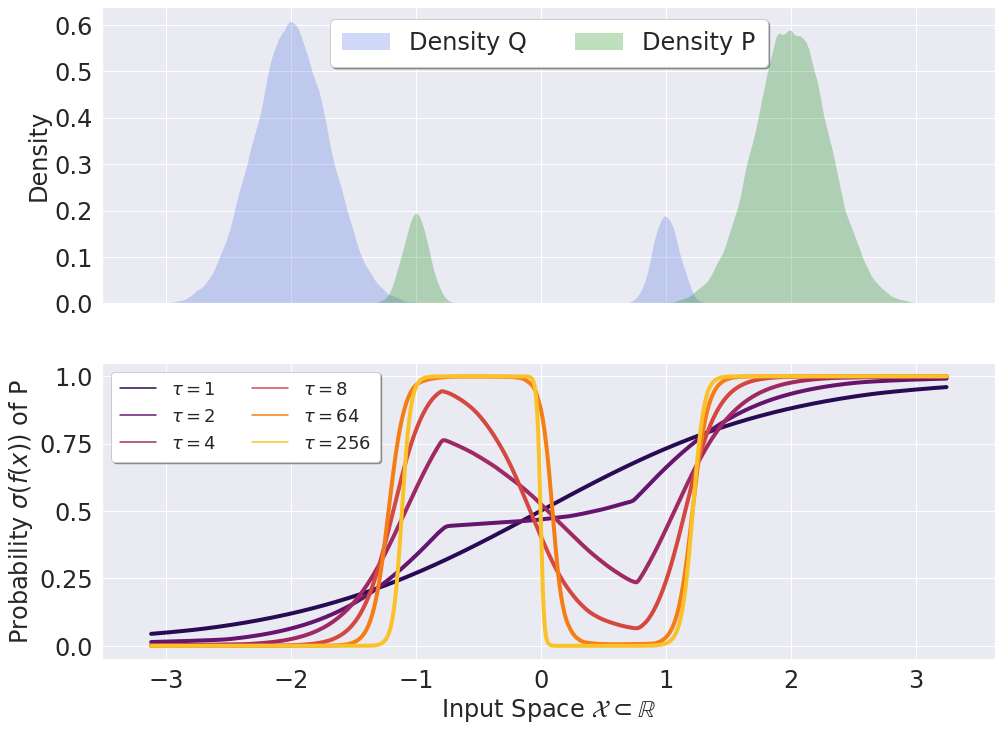

In [ ]:
plot_1D_toy('green', 'royalblue', 'inferno', must_return=True)

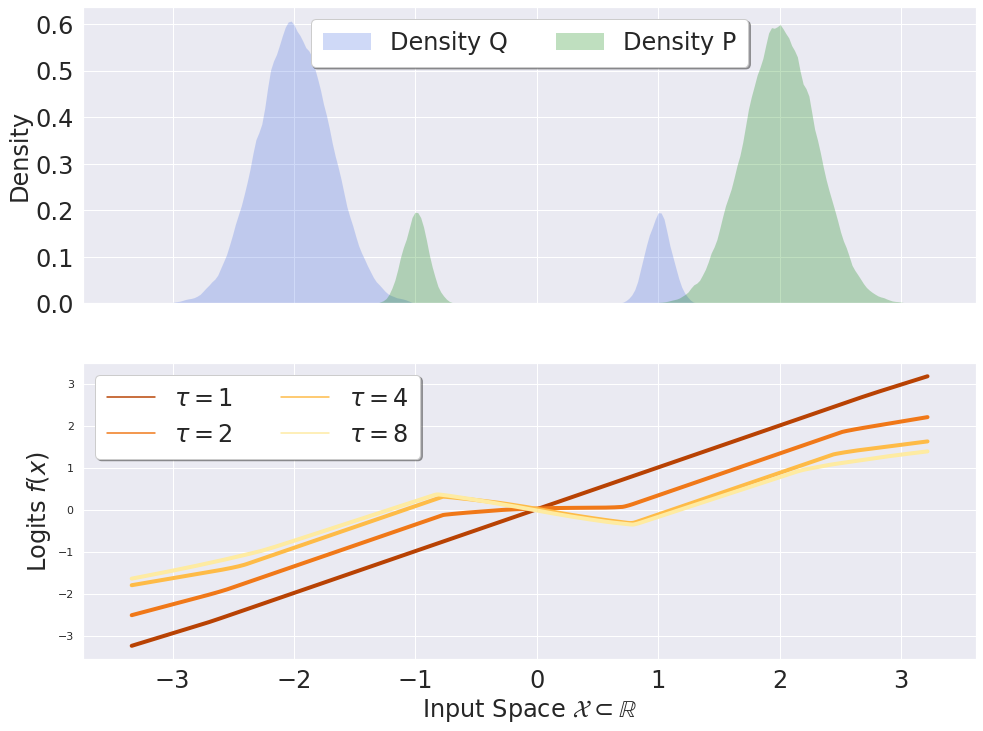

In [ ]:
plot_1D_toy('green', 'royalblue', 'YlOrBr_r', must_return=True, logits_plot=True)